# LM(Dirichlet)+GP experiments all

on the same data that the DGP paper uses with the same metrics

#TODO

In [1]:
import math
import torch
import numpy as np
import pandas as pd
import gpytorch
from matplotlib import pyplot as plt

In [2]:
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

In [3]:
import sys
import os

py_file_location = '../utils'
sys.path.append(os.path.abspath(py_file_location))
py_file_location = '../models'
sys.path.append(os.path.abspath(py_file_location))

import classification_utils
import classification_models

In [4]:
seed = 5 #1,2,3,4,5
np.random.seed(seed)
torch.manual_seed(seed)

# Load all datasets

We use three multi-dimensional classification datasets from the Dirichlet GPC paper (all from the UCI ML repository)
- letter recognition
- Mocap (hand gesture postures)
- drive (sensorless drive diagnosis)

In [5]:
# load drive data
df_DRIVE = pd.read_csv("data/Sensorless_drive_diagnosis.csv", header=None)
df_DRIVE.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,-3.014600e-07,8.260300e-06,-0.000012,-0.000002,-1.438600e-06,-0.000021,0.031718,0.031710,0.031721,-0.032963,...,-0.63308,2.9646,8.1198,-1.4961,-1.4961,-1.4961,-1.4996,-1.4996,-1.4996,0.0
1,2.913200e-06,-5.247700e-06,0.000003,-0.000006,2.778900e-06,-0.000004,0.030804,0.030810,0.030806,-0.033520,...,-0.59314,7.6252,6.1690,-1.4967,-1.4967,-1.4967,-1.5005,-1.5005,-1.5005,0.0
2,-2.951700e-06,-3.184000e-06,-0.000016,-0.000001,-1.575300e-06,0.000017,0.032877,0.032880,0.032896,-0.029834,...,-0.63252,2.7784,5.3017,-1.4983,-1.4983,-1.4982,-1.4985,-1.4985,-1.4985,0.0
3,-1.322600e-06,8.820100e-06,-0.000016,-0.000005,-7.282900e-07,0.000004,0.029410,0.029401,0.029417,-0.030156,...,-0.62289,6.5534,6.2606,-1.4963,-1.4963,-1.4963,-1.4975,-1.4975,-1.4976,0.0
4,-6.836600e-08,5.666300e-07,-0.000026,-0.000006,-7.940600e-07,0.000013,0.030119,0.030119,0.030145,-0.031393,...,-0.63010,4.5155,9.5231,-1.4958,-1.4958,-1.4958,-1.4959,-1.4959,-1.4959,0.0


In [6]:
# load letter data
df_LETTER = pd.read_csv("data/letter-recognition.csv", header=None)
# replace capital letter with corresponding numbers
df_LETTER.replace({
    "A":0, "B":1, "C":2, "D":3, "E":4, "F":5, "G": 6, "H":7, "I":8, "J": 9,
    "K":10, "L":11, "M":12, "N":13, "O":14, "P":15, "Q":16, "R":17, "S":18, "T":19, 
    "U":20, "V":21, "W":22, "X":23, "Y":24, "Z":25
}, inplace=True)
df_LETTER.head()
# Note that the first column are the targets rather than the last

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,19,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,8,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,3,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,13,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,6,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [7]:
# load mocap data
df_MOCAP = pd.read_csv("data/Postures.csv")
df_MOCAP.replace({"?":0}, inplace=True)
df_MOCAP = df_MOCAP.astype('float')
df_MOCAP.head()

# this dataset is a bit suspicious, honestly. There are a lot of ? values or zeros
# Note that the y value is the first column rather than the last, i.e. class

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Normalize and create test-train splits

# TODO

In [8]:
# make test-train split for DRIVE
from sklearn.model_selection import train_test_split

X_DRIVE = df_DRIVE.values[:,:-1]
Y_DRIVE = df_DRIVE.values[:,-1]
NUM_TRAINING_POINTS_DRIVE=48509 + 8000
NUM_TEST_POINTS_DRIVE=2000 # change from 10000 to 2000 for faster inference

# Normalize data
#X_DRIVE = classification_utils.standardise(X_DRIVE)
X_DRIVE = classification_utils.normalise_minusonetoone(X_DRIVE)

test_size_DRIVE = NUM_TEST_POINTS_DRIVE/(NUM_TRAINING_POINTS_DRIVE+NUM_TEST_POINTS_DRIVE)
X_DRIVE_train, X_DRIVE_test, y_DRIVE_train, y_DRIVE_test = train_test_split(X_DRIVE, Y_DRIVE, test_size=test_size_DRIVE, random_state=seed)
print(np.shape(X_DRIVE_train))
print(np.shape(X_DRIVE_test))
print(np.shape(y_DRIVE_train))
print(np.shape(y_DRIVE_test))
X_DRIVE_train, X_DRIVE_test, y_DRIVE_train, y_DRIVE_test = torch.tensor(X_DRIVE_train).float(), torch.tensor(X_DRIVE_test).float(), \
                                                   torch.tensor(y_DRIVE_train).long(), torch.tensor(y_DRIVE_test).long()
print(y_DRIVE_test[:20])

(56509, 48)
(2000, 48)
(56509,)
(2000,)
tensor([6, 9, 7, 8, 4, 5, 5, 2, 4, 5, 3, 2, 2, 2, 5, 9, 3, 1, 2, 9])


In [9]:
# make test-train split for LETTER
from sklearn.model_selection import train_test_split

X_LETTER = df_LETTER.values[:,1:]
Y_LETTER = df_LETTER.values[:,0]
NUM_TRAINING_POINTS_LETTER=15000 + 3000
NUM_TEST_POINTS_LETTER=2000 #changed from 5000 to 2000 for faster inference

# Normalize data
X_LETTER = classification_utils.standardise(X_LETTER)
#X_LETTER = classification_utils.normalise_minusonetoone(X_LETTER)

test_size_LETTER = NUM_TEST_POINTS_LETTER/(NUM_TRAINING_POINTS_LETTER+NUM_TEST_POINTS_LETTER)
X_LETTER_train, X_LETTER_test, y_LETTER_train, y_LETTER_test = train_test_split(X_LETTER, Y_LETTER, test_size=test_size_LETTER, random_state=seed)
print(np.shape(X_LETTER_train))
print(np.shape(X_LETTER_test))
print(np.shape(y_LETTER_train))
print(np.shape(y_LETTER_test))
X_LETTER_train, X_LETTER_test, y_LETTER_train, y_LETTER_test = torch.tensor(X_LETTER_train).float(), torch.tensor(X_LETTER_test).float(), \
                                                   torch.tensor(y_LETTER_train).long(), torch.tensor(y_LETTER_test).long()
print(y_LETTER_test[:20])

(18000, 16)
(2000, 16)
(18000,)
(2000,)
tensor([ 2,  9, 13, 12, 14, 15,  3, 19,  0,  4, 24,  7,  4, 10, 11,  0, 14, 19,
        23,  5])


In [10]:
# make test-train split for MOCAP
from sklearn.model_selection import train_test_split

X_MOCAP = df_MOCAP.values[1:,1:]
Y_MOCAP = df_MOCAP.values[1:,0]
NUM_TRAINING_POINTS_MOCAP=68094 + 8000
NUM_TEST_POINTS_MOCAP=2000 # changed from 10000 to 2000 for faster inference

## There is one row with class 0 which we don't want; therefore the 1: in the selection above
## class labels are 1-based indices; therefore -1
Y_MOCAP -= 1
print(torch.unique(torch.tensor(Y_MOCAP), return_counts=True))

# Normalize data
X_MOCAP = classification_utils.standardise(X_MOCAP)
#X_MOCAP = classification_utils.normalise_minusonetoone(X_MOCAP)


test_size_MOCAP = NUM_TEST_POINTS_MOCAP/(NUM_TRAINING_POINTS_MOCAP+NUM_TEST_POINTS_MOCAP)
X_MOCAP_train, X_MOCAP_test, y_MOCAP_train, y_MOCAP_test = train_test_split(X_MOCAP, Y_MOCAP, test_size=test_size_MOCAP, random_state=seed)
print(np.shape(X_MOCAP_train))
print(np.shape(X_MOCAP_test))
print(np.shape(y_MOCAP_train))
print(np.shape(y_MOCAP_test))
X_MOCAP_train, X_MOCAP_test, y_MOCAP_train, y_MOCAP_test = torch.tensor(X_MOCAP_train).float(), torch.tensor(X_MOCAP_test).float(), \
                                                   torch.tensor(y_MOCAP_train).long(), torch.tensor(y_MOCAP_test).long()
print(y_MOCAP_test[:20])

(tensor([0., 1., 2., 3., 4.], dtype=torch.float64), tensor([16265, 14978, 16344, 14775, 15733]))
(76094, 37)
(2001, 37)
(76094,)
(2001,)
tensor([1, 0, 0, 4, 2, 2, 2, 1, 1, 3, 2, 0, 1, 1, 2, 2, 4, 4, 0, 2])


## Create inducing points

As in the Dirichlet GPC paper, we use the following number of inducing points
TODO

In [11]:
NUM_INDUCING_POINTS_DRIVE=500
NUM_CLASSES_DRIVE=11
NUM_INDUCING_POINTS_LETTER=200
NUM_CLASSES_LETTER=26
NUM_INDUCING_POINTS_MOCAP=500
NUM_CLASSES_MOCAP=5

In [12]:
### DRIVE

## choose random inducing points
#X_DRIVE_train_induced, y_DRIVE_train_induced = classification_utils.random_inducing_points(X_DRIVE_train, y_DRIVE_train, NUM_INDUCING_POINTS_DRIVE)

## use kmeans for inducing points
X_DRIVE_train_induced, y_DRIVE_train_induced = classification_utils.k_means_inducing_points(X_DRIVE_train, y_DRIVE_train, NUM_INDUCING_POINTS_DRIVE)
print(X_DRIVE_train_induced[:2], y_DRIVE_train_induced[:2])

# use the conjugacy of the Beta to create better inducing points
X_DRIVE_train_induced, y_DRIVE_train_induced_alphas = classification_utils.k_means_inducing_points_LM_Dir(X_DRIVE_train,
                                                                                        y_DRIVE_train, NUM_INDUCING_POINTS_DRIVE, num_classes=NUM_CLASSES_DRIVE)
print(X_DRIVE_train_induced[:2], y_DRIVE_train_induced_alphas[:2])

tensor([[ 0.4059,  0.0845,  0.4175,  0.7936,  0.8223,  0.5671,  0.5303,  0.5214,
          0.5117, -0.3397, -0.3398, -0.3399, -0.9720, -0.9525, -0.9108, -0.9666,
         -0.9615, -0.8551,  0.3632,  0.3631,  0.3633,  0.3619,  0.3620,  0.3615,
         -0.2822, -0.0082, -0.1344, -0.2105,  0.0699,  0.0070, -0.1647, -0.1508,
         -0.1434,  0.2138,  0.2243,  0.2381, -0.9999, -0.9901, -0.9762, -0.9998,
         -0.9991, -0.8668, -0.3432, -0.3466, -0.4018, -0.6938, -0.6785, -0.6906],
        [ 0.4063,  0.0904,  0.4484,  0.7939,  0.8226,  0.5638,  0.1142,  0.0970,
          0.0736, -0.3469, -0.3471, -0.3472, -0.9941, -0.9837, -0.9908, -0.9932,
         -0.9897, -0.9839, -0.4976, -0.4977, -0.4974, -0.4956, -0.4956, -0.4953,
         -0.2832, -0.0063, -0.0603, -0.2106,  0.0727, -0.0144, -0.3055, -0.2902,
         -0.2828,  0.2695,  0.2805,  0.2930, -0.9999, -0.9344, -0.9635, -0.9999,
         -0.9921, -0.8116, -0.1900, -0.1954, -0.2463, -0.7557, -0.7398, -0.7568]]) tensor([8, 1])
tensor([[ 

In [13]:
### LETTER

## choose random inducing points
#X_LETTER_train_induced, y_LETTER_train_induced = classification_utils.random_inducing_points(X_LETTER_train, y_LETTER_train, NUM_INDUCING_POINTS_LETTER)

## use kmeans for inducing points
X_LETTER_train_induced, y_LETTER_train_induced = classification_utils.k_means_inducing_points(X_LETTER_train, y_LETTER_train, NUM_INDUCING_POINTS_LETTER)
print(X_LETTER_train_induced[:2], y_LETTER_train_induced[:2])

# use the conjugacy of the Beta to create better inducing points
X_LETTER_train_induced, y_LETTER_train_induced_alphas = classification_utils.k_means_inducing_points_LM_Dir(X_LETTER_train,
                                                                                        y_LETTER_train, NUM_INDUCING_POINTS_LETTER, num_classes=NUM_CLASSES_LETTER)
print(X_LETTER_train_induced[:2], y_LETTER_train_induced_alphas[:2])

tensor([[-0.5350, -0.6160, -0.0605, -0.6069, -0.2309,  1.0377, -0.2152, -0.6032,
         -0.0750,  0.6904, -0.9327, -0.9272, -0.0198, -0.8656,  0.1201,  1.3594],
        [ 1.0331,  0.8971,  0.4359,  1.1619,  0.2256, -0.4430, -0.2152,  0.5079,
          0.7650,  0.6904,  0.5876,  1.4760, -0.4485,  0.4275,  0.5096,  0.7412]]) tensor([17,  6])
tensor([[-0.5350, -0.6160, -0.0605, -0.6069, -0.2309,  1.0377, -0.2152, -0.6032,
         -0.0750,  0.6904, -0.9327, -0.9272, -0.0198, -0.8656,  0.1201,  1.3594],
        [ 1.0331,  0.8971,  0.4359,  1.1619,  0.2256, -0.4430, -0.2152,  0.5079,
          0.7650,  0.6904,  0.5876,  1.4760, -0.4485,  0.4275,  0.5096,  0.7412]]) tensor([[1.0000e-03, 4.2001e+01, 1.0000e-03, 8.0010e+00, 6.0010e+00, 1.0000e-03,
         1.0000e-03, 8.0010e+00, 1.0010e+00, 1.0000e-03, 2.0010e+00, 1.0000e-03,
         1.0000e-03, 1.0000e-03, 1.0000e-03, 1.0000e-03, 1.0000e-03, 5.1001e+01,
         9.0010e+00, 1.0000e-03, 1.0000e-03, 1.0000e-03, 1.0000e-03, 9.0010e+00,
     

In [14]:
### MOCAP

## choose random inducing points
#X_MOCAP_train_induced, y_MOCAP_train_induced = classification_utils.random_inducing_points(X_MOCAP_train, y_MOCAP_train, NUM_INDUCING_POINTS_MOCAP)

## use kmeans for inducing points
X_MOCAP_train_induced, y_MOCAP_train_induced = classification_utils.k_means_inducing_points(X_MOCAP_train, y_MOCAP_train, NUM_INDUCING_POINTS_MOCAP)
print(X_MOCAP_train_induced[:2], y_MOCAP_train_induced[:2])

# use the conjugacy of the Beta to create better inducing points
X_MOCAP_train_induced, y_MOCAP_train_induced_alphas = classification_utils.k_means_inducing_points_LM_Dir(X_MOCAP_train,
                                                                                        y_MOCAP_train, NUM_INDUCING_POINTS_MOCAP, num_classes=NUM_CLASSES_MOCAP)
print(X_MOCAP_train_induced[:2], y_MOCAP_train_induced_alphas[:2])

tensor([[ 4.3442e-01, -1.1592e+00, -2.6350e-01, -6.2451e-01,  5.4568e-01,
         -7.3819e-01, -1.5848e+00, -3.9694e-01, -2.0534e-01, -8.1469e-01,
         -1.7074e+00, -2.0580e-01, -2.1696e-01,  2.5252e-01, -3.1371e-01,
         -1.1410e+00,  8.9940e-01, -7.6142e-01, -1.7046e+00,  7.3873e-01,
         -1.1810e+00, -1.9527e+00, -6.3254e-01, -8.3749e-01,  3.9001e-01,
         -5.5957e-01, -6.8151e-01,  3.7657e-01, -5.0031e-01, -5.6139e-01,
          3.5788e-01, -3.7788e-01, -4.0576e-01,  2.7000e-01,  1.0254e-02,
         -1.1602e-02, -1.7143e-03],
        [ 2.2155e-01, -7.0453e-01,  1.6865e+00,  3.9788e-01, -3.7464e-02,
          1.7460e+00,  4.0509e-01, -1.1805e-01,  4.3969e-01,  5.1064e-01,
          1.2124e+00, -8.3969e-01,  1.1529e-01, -6.7954e-01,  5.7463e-01,
          4.9048e-01, -1.0169e+00,  4.0242e-01,  1.2042e-01,  1.0539e+00,
          7.2435e-01, -5.6076e-02,  1.9339e+00,  4.7050e-01, -4.6639e-01,
          1.3668e+00,  2.1171e+00, -4.7125e-01, -2.3864e-01,  2.2962e+00,
  

# Setup for GPC & LB(Dirichlet)+GP

In [15]:
LENGTHSCALES = [0.01, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50]

## DRIVE

In [16]:
### choose lengthscale with CV
#NUM_ITER_DRIVE = 200 #Seems to differ between the methods
LR_DRIVE = 0.1
"""
res_DRIVE = classification_models.select_init_lengthscale_with_CV_Dir(X_DRIVE_train, y_DRIVE_train, mode="DGP",
                                    num_inducing_points=NUM_INDUCING_POINTS_DRIVE, 
                                    learn_noise=True, num_iter=400, lr=LR_DRIVE,
                                    lengthscales=LENGTHSCALES, max_test_size=1000)
print(res_DRIVE)    
classification_utils.plot_res(res_DRIVE)
#"""

INIT_LENGHTSCALE_DRIVE = 5

In [17]:
### run Dirichlet GPC

DGP_model, DGP_likelihood = classification_models.create_DGP_model(X_DRIVE_train_induced, y_DRIVE_train_induced,
                                        init_lengthscale=INIT_LENGHTSCALE_DRIVE, learn_additional_noise=True)
DGP_model, DGP_likelihood = classification_models.train_DGP_model(X_DRIVE_train_induced,
                                DGP_model, DGP_likelihood, num_iter=500, lr=LR_DRIVE, report_iter=50)
DRIVE_DGP_res = classification_models.evaluate_DGP(DGP_model, DGP_likelihood, X_DRIVE_test, y_DRIVE_test)
print(DRIVE_DGP_res)

Iter 1/500 - Loss: 28.961   lengthscale: 5.000   noise: 0.693
Iter 51/500 - Loss: 23.952   lengthscale: 2.332   noise: 2.526
Iter 101/500 - Loss: 23.484   lengthscale: 2.191   noise: 1.916
Iter 151/500 - Loss: 23.344   lengthscale: 1.956   noise: 1.539
Iter 201/500 - Loss: 23.216   lengthscale: 1.431   noise: 1.304
Iter 251/500 - Loss: 23.088   lengthscale: 1.163   noise: 0.951
Iter 301/500 - Loss: 23.032   lengthscale: 1.066   noise: 0.704
Iter 351/500 - Loss: 23.005   lengthscale: 0.880   noise: 0.567
Iter 401/500 - Loss: 22.863   lengthscale: 0.557   noise: 0.350
Iter 451/500 - Loss: 22.767   lengthscale: 0.553   noise: 0.104
(0.9204999804496765, 0.338476300239563, 0.12681159377098083)


In [18]:
### Run LM(Beta)+GP vanilla
y_DRIVE_train_induced_mu, y_DRIVE_train_induced_var = classification_models.transform_y_Dir_LM(y_DRIVE_train_induced,
                                                                                    a_eps=0.00001, num_classes=NUM_CLASSES_DRIVE)
LMGP_model_DRIVE, LMGP_likelihood_DRIVE = classification_models.create_LM_Dir_GP_model(X_DRIVE_train_induced, 
                                y_DRIVE_train_induced_mu, y_DRIVE_train_induced_var, num_classes=NUM_CLASSES_DRIVE,
                                init_lengthscale=INIT_LENGHTSCALE_DRIVE, rank=NUM_CLASSES_DRIVE)

LMGP_model_DRIVE, LMGP_likelihood_DRIVE = classification_models.train_LM_Dir_GP_model(X_DRIVE_train_induced, y_DRIVE_train_induced_mu, 
                        LMGP_model_DRIVE, LMGP_likelihood_DRIVE, num_iter=100, lr=LR_DRIVE, report_iter=20)
DRIVE_LMGP_res = classification_models.evaluate_LM_Dir_GP(LMGP_model_DRIVE, LMGP_likelihood_DRIVE, 
                                                          X_DRIVE_test, y_DRIVE_test, num_samples=1000)
print(DRIVE_LMGP_res)

Iter 1/100 - Loss: 2.795; lengthscale: 0.693; noise: 0.693
Iter 21/100 - Loss: 2.222; lengthscale: 0.393; noise: 1.021
Iter 41/100 - Loss: 2.147; lengthscale: 0.380; noise: 0.499
Iter 61/100 - Loss: 2.075; lengthscale: 0.368; noise: 0.170
Iter 81/100 - Loss: 2.023; lengthscale: 0.366; noise: 0.065
(0.9390000104904175, 0.2649153470993042, 0.06474262475967407)


In [19]:
### Run LM(Beta)+GP with conjugacy information

train_mu_LB_con_DRIVE = classification_models.Dirichlet_bridge_mu_batch(y_DRIVE_train_induced_alphas)
train_var_LB_con_DRIVE = classification_models.Dirichlet_bridge_Sigma_diag_batch(y_DRIVE_train_induced_alphas)
LMGP_model_con_DRIVE, LMGP_likelihood_con_DRIVE = classification_models.create_LM_Dir_GP_model(X_DRIVE_train_induced, train_mu_LB_con_DRIVE,
                                                train_var_LB_con_DRIVE, num_classes=NUM_CLASSES_DRIVE,
                                                init_lengthscale=INIT_LENGHTSCALE_DRIVE, rank=NUM_CLASSES_DRIVE)
LMGP_model_con_DRIVE, LMGP_likelihood_con_DRIVE = classification_models.train_LM_Dir_GP_model(X_DRIVE_train_induced, train_mu_LB_con_DRIVE,
                LMGP_model_con_DRIVE, LMGP_likelihood_con_DRIVE, num_iter=100, lr=LR_DRIVE, report_iter=20)

DRIVE_LMGP_con_res = classification_models.evaluate_LM_Dir_GP(LMGP_model_con_DRIVE, LMGP_likelihood_con_DRIVE, 
                                            X_DRIVE_test, y_DRIVE_test, num_samples=1000)
print(DRIVE_LMGP_con_res)

Iter 1/100 - Loss: 2.928; lengthscale: 0.693; noise: 0.693
Iter 21/100 - Loss: 2.288; lengthscale: 0.381; noise: 1.215
Iter 41/100 - Loss: 2.241; lengthscale: 0.421; noise: 0.911
Iter 61/100 - Loss: 2.207; lengthscale: 0.382; noise: 0.516
Iter 81/100 - Loss: 2.179; lengthscale: 0.347; noise: 0.263
(0.921500027179718, 0.19454345107078552, 0.04535232111811638)


## LETTER

In [20]:
### choose lengthscale with CV
#NUM_ITER_LETTER = 200 #Seems to differ between the methods
LR_LETTER = 0.1
"""
res_LETTER = classification_models.select_init_lengthscale_with_CV_Dir(X_LETTER_train, y_LETTER_train, mode="LMGP_dir",
                                    num_inducing_points=NUM_INDUCING_POINTS_LETTER, 
                                    learn_noise=True, num_iter=100, lr=LR_LETTER, num_classes=NUM_CLASSES_LETTER,
                                    lengthscales=LENGTHSCALES, max_test_size=1000)
print(res_LETTER)    
classification_utils.plot_res(res_LETTER)
#"""

INIT_LENGHTSCALE_LETTER = 1

In [21]:
### run Dirichlet GPC

DGP_model, DGP_likelihood = classification_models.create_DGP_model(X_LETTER_train_induced, y_LETTER_train_induced,
                                        init_lengthscale=INIT_LENGHTSCALE_LETTER, learn_additional_noise=True)
DGP_model, DGP_likelihood = classification_models.train_DGP_model(X_LETTER_train_induced,
                                DGP_model, DGP_likelihood, num_iter=100, lr=LR_LETTER, report_iter=50)
LETTER_DGP_res = classification_models.evaluate_DGP(DGP_model, DGP_likelihood, X_LETTER_test, y_LETTER_test)
print(LETTER_DGP_res)

Iter 1/100 - Loss: 141.764   lengthscale: 1.000   noise: 0.693
Iter 51/100 - Loss: 56.050   lengthscale: 3.551   noise: 1.520
(0.5835000276565552, 1.7394791841506958, 0.2348499745130539)


In [22]:
### Run LM(Beta)+GP vanilla
y_LETTER_train_induced_mu, y_LETTER_train_induced_var = classification_models.transform_y_Dir_LM(y_LETTER_train_induced,
                                                                                    a_eps=0.00001, num_classes=NUM_CLASSES_LETTER)
LMGP_model_LETTER, LMGP_likelihood_LETTER = classification_models.create_LM_Dir_GP_model(X_LETTER_train_induced, 
                                y_LETTER_train_induced_mu, y_LETTER_train_induced_var, num_classes=NUM_CLASSES_LETTER,
                                init_lengthscale=INIT_LENGHTSCALE_LETTER, rank=NUM_CLASSES_LETTER)

LMGP_model_LETTER, LMGP_likelihood_LETTER = classification_models.train_LM_Dir_GP_model(X_LETTER_train_induced, y_LETTER_train_induced_mu, 
                        LMGP_model_LETTER, LMGP_likelihood_LETTER, num_iter=100, lr=LR_LETTER, report_iter=20)
LETTER_LMGP_res = classification_models.evaluate_LM_Dir_GP(LMGP_model_LETTER, LMGP_likelihood_LETTER, 
                                                          X_LETTER_test, y_LETTER_test, num_samples=1000)
print(LETTER_LMGP_res)

Iter 1/100 - Loss: 2.592; lengthscale: 0.693; noise: 0.693
Iter 21/100 - Loss: 2.095; lengthscale: 2.049; noise: 0.377
Iter 41/100 - Loss: 2.036; lengthscale: 2.486; noise: 0.182
Iter 61/100 - Loss: 2.005; lengthscale: 2.558; noise: 0.040
Iter 81/100 - Loss: 1.995; lengthscale: 2.791; noise: 0.017
(0.5295000076293945, 1.8237632513046265, 0.05229999125003815)


In [23]:
### Run LM(Beta)+GP with conjugacy information

train_mu_LB_con_LETTER = classification_models.Dirichlet_bridge_mu_batch(y_LETTER_train_induced_alphas)
train_var_LB_con_LETTER = classification_models.Dirichlet_bridge_Sigma_diag_batch(y_LETTER_train_induced_alphas)
LMGP_model_con_LETTER, LMGP_likelihood_con_LETTER = classification_models.create_LM_Dir_GP_model(X_LETTER_train_induced, train_mu_LB_con_LETTER,
                                                train_var_LB_con_LETTER, num_classes=NUM_CLASSES_LETTER,
                                                init_lengthscale=INIT_LENGHTSCALE_LETTER, rank=NUM_CLASSES_LETTER)
LMGP_model_con_LETTER, LMGP_likelihood_con_LETTER = classification_models.train_LM_Dir_GP_model(X_LETTER_train_induced, train_mu_LB_con_LETTER,
                LMGP_model_con_LETTER, LMGP_likelihood_con_LETTER, num_iter=100, lr=LR_LETTER, report_iter=20)

LETTER_LMGP_con_res = classification_models.evaluate_LM_Dir_GP(LMGP_model_con_LETTER, LMGP_likelihood_con_LETTER, 
                                            X_LETTER_test, y_LETTER_test, num_samples=1000)
print(LETTER_LMGP_con_res)

Iter 1/100 - Loss: 2.937; lengthscale: 0.693; noise: 0.693
Iter 21/100 - Loss: 2.401; lengthscale: 2.064; noise: 0.860
Iter 41/100 - Loss: 2.360; lengthscale: 2.019; noise: 1.202
Iter 61/100 - Loss: 2.349; lengthscale: 1.876; noise: 0.995
Iter 81/100 - Loss: 2.345; lengthscale: 1.857; noise: 0.703
(0.6244999766349792, 1.1092967987060547, 0.03605000302195549)


## MOCAP

In [24]:
### choose lengthscale with CV
#NUM_ITER_MOCAP = 200 #Seems to differ between the methods
LR_MOCAP = 0.1
"""
res_MOCAP = classification_models.select_init_lengthscale_with_CV_Dir(X_MOCAP_train, y_MOCAP_train, mode="GPC",
                                    num_inducing_points=NUM_INDUCING_POINTS_MOCAP, 
                                    learn_noise=True, num_iter=100, lr=LR_MOCAP, num_classes=NUM_CLASSES_MOCAP,
                                    lengthscales=LENGTHSCALES, max_test_size=1000)
print(res_MOCAP)    
classification_utils.plot_res(res_MOCAP)
#"""

INIT_LENGHTSCALE_MOCAP = 1

In [25]:
### run Dirichlet GPC

DGP_model, DGP_likelihood = classification_models.create_DGP_model(X_MOCAP_train_induced, y_MOCAP_train_induced,
                                        init_lengthscale=INIT_LENGHTSCALE_MOCAP, learn_additional_noise=True)
DGP_model, DGP_likelihood = classification_models.train_DGP_model(X_MOCAP_train_induced,
                                DGP_model, DGP_likelihood, num_iter=200, lr=LR_MOCAP, report_iter=50)
MOCAP_DGP_res = classification_models.evaluate_DGP(DGP_model, DGP_likelihood, X_MOCAP_test, y_MOCAP_test)
print(MOCAP_DGP_res)

Iter 1/200 - Loss: 24.427   lengthscale: 1.000   noise: 0.693
Iter 51/200 - Loss: 10.932   lengthscale: 4.298   noise: 1.653
Iter 101/200 - Loss: 10.645   lengthscale: 4.748   noise: 0.687
Iter 151/200 - Loss: 10.544   lengthscale: 4.835   noise: 0.362
(0.7836081981658936, 0.605052649974823, 0.04935096949338913)


In [26]:
### Run LM(Beta)+GP vanilla
y_MOCAP_train_induced_mu, y_MOCAP_train_induced_var = classification_models.transform_y_Dir_LM(y_MOCAP_train_induced,
                                                                                    a_eps=0.00001, num_classes=NUM_CLASSES_MOCAP)
LMGP_model_MOCAP, LMGP_likelihood_MOCAP = classification_models.create_LM_Dir_GP_model(X_MOCAP_train_induced, 
                                y_MOCAP_train_induced_mu, y_MOCAP_train_induced_var, num_classes=NUM_CLASSES_MOCAP,
                                init_lengthscale=INIT_LENGHTSCALE_MOCAP, rank=NUM_CLASSES_MOCAP)

LMGP_model_MOCAP, LMGP_likelihood_MOCAP = classification_models.train_LM_Dir_GP_model(X_MOCAP_train_induced, y_MOCAP_train_induced_mu, 
                        LMGP_model_MOCAP, LMGP_likelihood_MOCAP, num_iter=100, lr=LR_MOCAP, report_iter=20)
MOCAP_LMGP_res = classification_models.evaluate_LM_Dir_GP(LMGP_model_MOCAP, LMGP_likelihood_MOCAP, 
                                                          X_MOCAP_test, y_MOCAP_test, num_samples=1000)
print(MOCAP_LMGP_res)

Iter 1/100 - Loss: 4.172; lengthscale: 0.693; noise: 0.693
Iter 21/100 - Loss: 2.513; lengthscale: 2.183; noise: 1.321
Iter 41/100 - Loss: 2.280; lengthscale: 3.908; noise: 1.019
Iter 61/100 - Loss: 2.177; lengthscale: 4.394; noise: 0.556
Iter 81/100 - Loss: 2.101; lengthscale: 4.225; noise: 0.241
(0.8235881924629211, 0.5502731204032898, 0.023539690300822258)


In [27]:
### Run LM(Beta)+GP with conjugacy information

train_mu_LB_con_MOCAP = classification_models.Dirichlet_bridge_mu_batch(y_MOCAP_train_induced_alphas)
train_var_LB_con_MOCAP = classification_models.Dirichlet_bridge_Sigma_diag_batch(y_MOCAP_train_induced_alphas)
LMGP_model_con_MOCAP, LMGP_likelihood_con_MOCAP = classification_models.create_LM_Dir_GP_model(X_MOCAP_train_induced, train_mu_LB_con_MOCAP,
                                                train_var_LB_con_MOCAP, num_classes=NUM_CLASSES_MOCAP,
                                                init_lengthscale=INIT_LENGHTSCALE_MOCAP, rank=NUM_CLASSES_MOCAP)
LMGP_model_con_MOCAP, LMGP_likelihood_con_MOCAP = classification_models.train_LM_Dir_GP_model(X_MOCAP_train_induced, train_mu_LB_con_MOCAP,
                LMGP_model_con_MOCAP, LMGP_likelihood_con_MOCAP, num_iter=100, lr=LR_MOCAP, report_iter=20)

MOCAP_LMGP_con_res = classification_models.evaluate_LM_Dir_GP(LMGP_model_con_MOCAP, LMGP_likelihood_con_MOCAP, 
                                            X_MOCAP_test, y_MOCAP_test, num_samples=1000)
print(MOCAP_LMGP_con_res)

Iter 1/100 - Loss: 3.890; lengthscale: 0.693; noise: 0.693
Iter 21/100 - Loss: 2.426; lengthscale: 2.198; noise: 1.257
Iter 41/100 - Loss: 2.253; lengthscale: 3.855; noise: 0.882
Iter 61/100 - Loss: 2.230; lengthscale: 4.029; noise: 0.713
Iter 81/100 - Loss: 2.204; lengthscale: 3.654; noise: 0.549
(0.7676162123680115, 0.6148572564125061, 0.03458084538578987)


# Save results

In [28]:
all_res = {
    "DRIVE_res":{
        "DGP":list(DRIVE_DGP_res), 
        "LMGP":list(DRIVE_LMGP_res), 
        "LMGP_con":list(DRIVE_LMGP_con_res)
    },
    "LETTER_res":{
        "DGP":list(LETTER_DGP_res), 
        "LMGP":list(LETTER_LMGP_res), 
        "LMGP_con":list(LETTER_LMGP_con_res)
    },
    "MOCAP_res":{
        "DGP":list(MOCAP_DGP_res), 
        "LMGP":list(MOCAP_LMGP_res), 
        "LMGP_con":list(MOCAP_LMGP_con_res)
    }
}

In [29]:
import json
print(all_res)
#save results for this seed

res_file = open("results/mult_class_seed_{}.json".format(seed), "w")
json.dump(all_res, res_file)
res_file.close()

{'DRIVE_res': {'DGP': [0.9204999804496765, 0.338476300239563, 0.12681159377098083], 'LMGP': [0.9390000104904175, 0.2649153470993042, 0.06474262475967407], 'LMGP_con': [0.921500027179718, 0.19454345107078552, 0.04535232111811638]}, 'LETTER_res': {'DGP': [0.5835000276565552, 1.7394791841506958, 0.2348499745130539], 'LMGP': [0.5295000076293945, 1.8237632513046265, 0.05229999125003815], 'LMGP_con': [0.6244999766349792, 1.1092967987060547, 0.03605000302195549]}, 'MOCAP_res': {'DGP': [0.7836081981658936, 0.605052649974823, 0.04935096949338913], 'LMGP': [0.8235881924629211, 0.5502731204032898, 0.023539690300822258], 'LMGP_con': [0.7676162123680115, 0.6148572564125061, 0.03458084538578987]}}


In [30]:
break

SyntaxError: 'break' outside loop (<ipython-input-30-6aaf1f276005>, line 1)

# Plot Results

In [31]:
### over all seeds

DGP_acc_all = []
LMGP_acc_all = []
LMGP_con_acc_all = []
DGP_mnll_all = []
LMGP_mnll_all = []
LMGP_con_mnll_all = []
DGP_ece_all = []
LMGP_ece_all = []
LMGP_con_ece_all = []

for seed in range(5):
    seed +=1

    with open('results/mult_class_seed_{}.json'.format(seed)) as json_file:
        all_res = json.load(json_file)
    print(all_res)

    DGP_acc = []
    LMGP_acc = []
    LMGP_con_acc = []
    DGP_mnll = []
    LMGP_mnll = []
    LMGP_con_mnll = []
    DGP_ece = []
    LMGP_ece = []
    LMGP_con_ece = []

    for dataset in ["DRIVE_res", "LETTER_res", "MOCAP_res"]:

        DGP_acc.append(all_res[dataset]["DGP"][0])
        LMGP_acc.append(all_res[dataset]["LMGP"][0])
        LMGP_con_acc.append(all_res[dataset]["LMGP_con"][0])
        DGP_mnll.append(all_res[dataset]["DGP"][1])
        LMGP_mnll.append(all_res[dataset]["LMGP"][1])
        LMGP_con_mnll.append(all_res[dataset]["LMGP_con"][1])
        DGP_ece.append(all_res[dataset]["DGP"][2])
        LMGP_ece.append(all_res[dataset]["LMGP"][2])
        LMGP_con_ece.append(all_res[dataset]["LMGP_con"][2])
        
    DGP_acc_all.append(DGP_acc)
    LMGP_acc_all.append(LMGP_acc)
    LMGP_con_acc_all.append(LMGP_con_acc)
    DGP_mnll_all.append(DGP_mnll)
    LMGP_mnll_all.append(LMGP_mnll)
    LMGP_con_mnll_all.append(LMGP_con_mnll)
    DGP_ece_all.append(DGP_ece)
    LMGP_ece_all.append(LMGP_ece)
    LMGP_con_ece_all.append(LMGP_con_ece)
    
DGP_acc_mean = np.array(DGP_acc_all).mean(0)
LMGP_acc_mean = np.array(LMGP_acc_all).mean(0)
LMGP_con_acc_mean = np.array(LMGP_con_acc_all).mean(0)
DGP_mnll_mean = np.array(DGP_mnll_all).mean(0)
LMGP_mnll_mean = np.array(LMGP_mnll_all).mean(0)
LMGP_con_mnll_mean = np.array(LMGP_con_mnll_all).mean(0)
DGP_ece_mean = np.array(DGP_ece_all).mean(0)
LMGP_ece_mean = np.array(LMGP_ece_all).mean(0)
LMGP_con_ece_mean = np.array(LMGP_con_ece_all).mean(0)

DGP_acc_std = np.array(DGP_acc_all).std(0)
LMGP_acc_std = np.array(LMGP_acc_all).std(0)
LMGP_con_acc_std = np.array(LMGP_con_acc_all).std(0)
DGP_mnll_std = np.array(DGP_mnll_all).std(0)
LMGP_mnll_std = np.array(LMGP_mnll_all).std(0)
LMGP_con_mnll_std = np.array(LMGP_con_mnll_all).std(0)
DGP_ece_std = np.array(DGP_ece_all).std(0)
LMGP_ece_std = np.array(LMGP_ece_all).std(0)
LMGP_con_ece_std = np.array(LMGP_con_ece_all).std(0)

{'DRIVE_res': {'DGP': [0.8535000085830688, 0.4916830360889435, 0.09887556731700897], 'LMGP': [0.9265000224113464, 0.3190912902355194, 0.030559713020920753], 'LMGP_con': [0.9179999828338623, 0.20655500888824463, 0.04230386018753052]}, 'LETTER_res': {'DGP': [0.5824999809265137, 1.7515902519226074, 0.24534998834133148], 'LMGP': [0.5879999995231628, 1.6532588005065918, 0.04524999111890793], 'LMGP_con': [0.6255000233650208, 1.0757890939712524, 0.0345500111579895]}, 'MOCAP_res': {'DGP': [0.8095952272415161, 0.5109665393829346, 0.02458813786506653], 'LMGP': [0.8450774550437927, 0.5338602066040039, 0.01964554190635681], 'LMGP_con': [0.7951024770736694, 0.5216256380081177, 0.021756496280431747]}}
{'DRIVE_res': {'DGP': [0.8475000262260437, 0.49802321195602417, 0.10497252643108368], 'LMGP': [0.9259999990463257, 0.3037663996219635, 0.03585707023739815], 'LMGP_con': [0.9079999923706055, 0.22206613421440125, 0.03520742058753967]}, 'LETTER_res': {'DGP': [0.5615000128746033, 1.7741894721984863, 0.2242

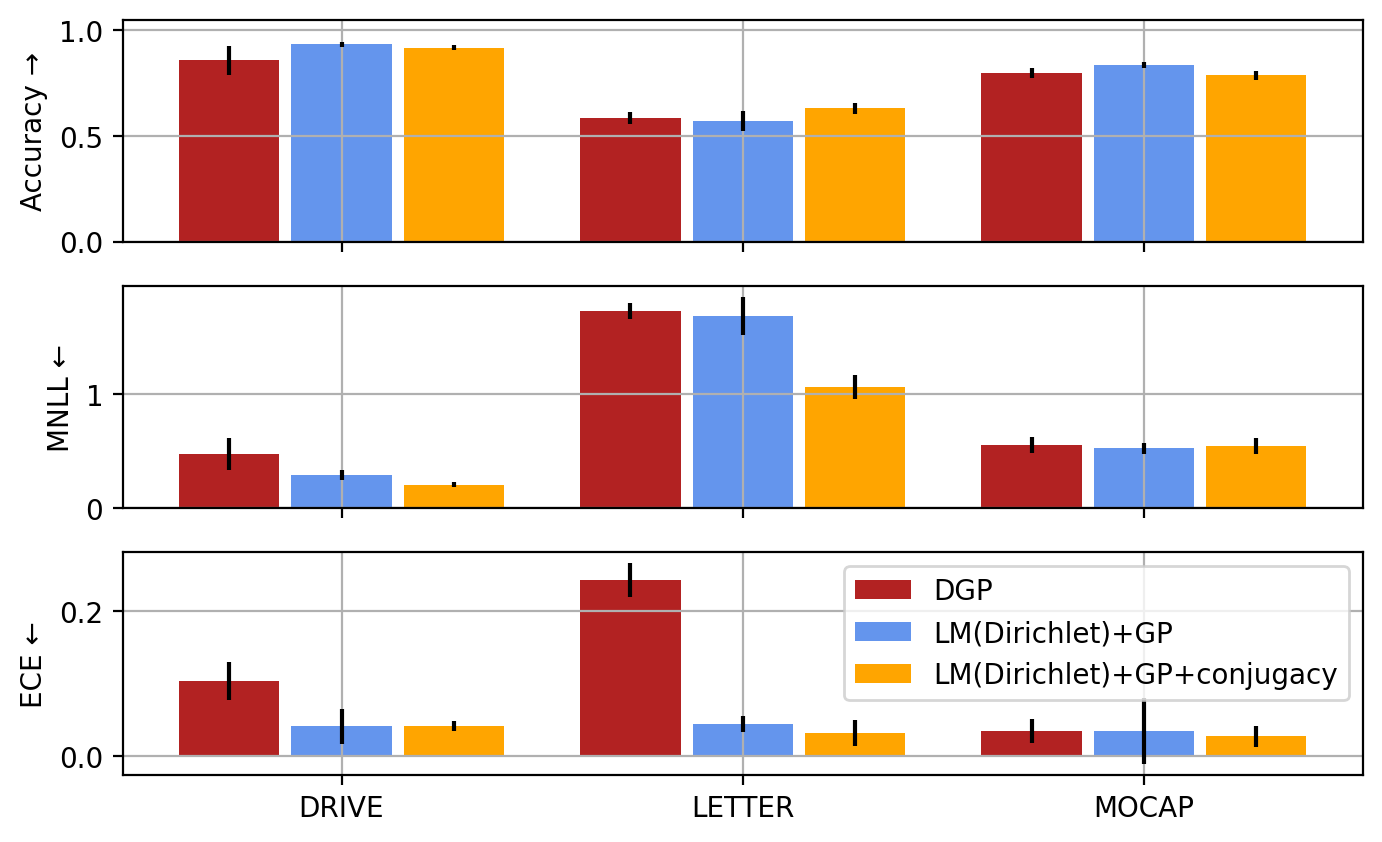

In [34]:
# plot the results
w=0.25
c=0.28
x=np.arange(3)

fig, ax = plt.subplots(3, 1, figsize=(8, 5), dpi=200, sharex=True)

ax[0].bar(x-1*c, DGP_acc_mean, width=w, yerr=2*DGP_acc_std, color="firebrick", label="DGP")
ax[0].bar(x, LMGP_acc_mean, width=w, yerr=2*LMGP_acc_std, color="cornflowerblue", label="LM(Dirichlet)+GP")
ax[0].bar(x+1*c, LMGP_con_acc_mean, width=w, yerr=2*LMGP_con_acc_std, color="orange", label="LM(Dirichlet)+GP+conjugacy")
ax[0].grid()
ax[0].set_ylim(0, 1.05)
ax[0].set_ylabel(u"Accuracy \u2192")
#ax[0].legend()

ax[1].bar(x-1*c, DGP_mnll_mean, width=w, yerr=2*DGP_mnll_std, color="firebrick", label="DGP")
ax[1].bar(x, LMGP_mnll_mean, width=w, yerr=2*LMGP_mnll_std, color="cornflowerblue", label="LM(Dirichlet)+GP")
ax[1].bar(x+1*c, LMGP_con_mnll_mean, width=w, yerr=2*LMGP_con_mnll_std, color="orange", label="LM(Dirichlet)+GP+conjugacy")
ax[1].grid()
ax[1].set_ylabel(u"MNLL \u2190")

ax[2].bar(x-1*c, DGP_ece_mean, width=w, yerr=2*DGP_ece_std, color="firebrick", label="DGP")
ax[2].bar(x, LMGP_ece_mean, width=w, yerr=2*LMGP_ece_std, color="cornflowerblue", label="LM(Dirichlet)+GP")
ax[2].bar(x+1*c, LMGP_con_ece_mean, width=w, yerr=2*LMGP_con_ece_std, color="orange", label="LM(Dirichlet)+GP+conjugacy")
ax[2].grid()
ax[2].set_ylabel(u"ECE \u2190")
ax[2].legend()

ax[2].set_xticks(x)
ax[2].set_xticklabels(["DRIVE", "LETTER", "MOCAP"])

plt.show();